In [1]:
import matplotlib.pyplot as pyplot
import numpy as np
import plotly
import seaborn as sns
import pandas as pd
import json
import os

path = "conversations"
# load json files from folder, with each json in format <id>_<rand>.json
# return a list of json objects
def load_profiles(path):
    profiles = []
    for filename in os.listdir(path):
        if filename.endswith(".json"):
            with open(os.path.join(path, filename)) as f:
                profiles.append(json.load(f))
    return profiles

profiles = load_profiles(path)

In [2]:
profiles

[{'profile': {'patient_id': 0,
   'ethnicity': 'asian',
   'gender': 'man',
   'diagnosis': 'melanoma',
   'revealed_symptoms': {'diameter >6mm': 'It’s bigger than the eraser on a pencil, and I feel like it’s still growing.',
    'induration': "It feels thicker or harder than the rest of my skin, like there's something under there.",
    'shiny or waxy bump': 'It looks kinda like a smooth, shiny pimple, but it never pops or goes away.'},
   'hidden_symptoms': {'pruritus': 'It’s super itchy sometimes, or feels kind of tingly, like a weird sensation under my skin.',
    'asymmetry': "One side of this mole looks different from the other, like it's lopsided or uneven.",
    'color variation': 'It’s got a bunch of different colors—like brown, black, maybe even some red or blue mixed in.',
    'satellite lesions': 'There are these little dots or spots popping up near the main one, like it’s spreading.',
    'border irregularity': 'The edges are all jagged, kinda messy, not smooth like my oth

C:\Users\willi\AppData\Local\Temp\ipykernel_62644\3814538871.py:56: RuntimeWarning: Mean of empty slice
  avg_conf = np.nanmean(all_confidences, axis=0)


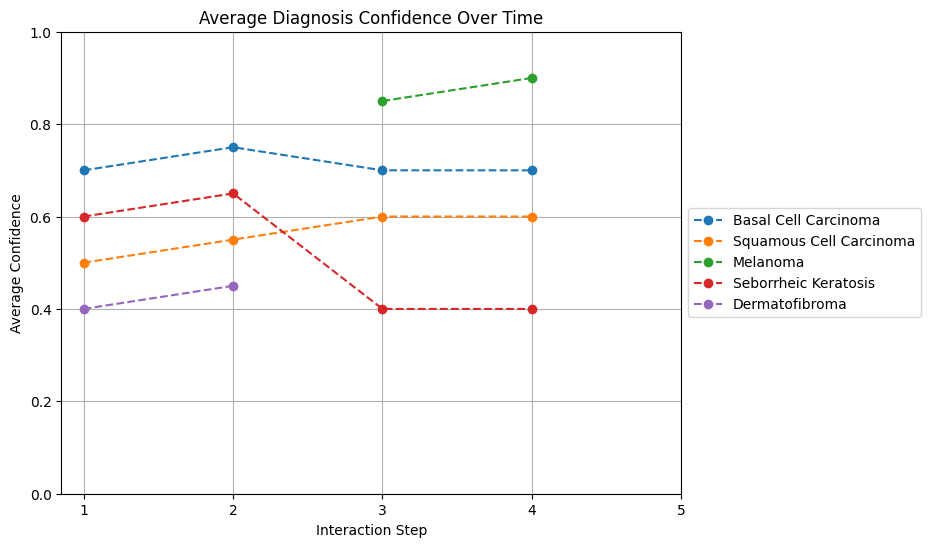

In [33]:
import numpy as np
import matplotlib.pyplot as plt


def plot_avg_diagnosis_confidence(profiles, filters=None, 
                                  specific_diagnoses=None, top_k=None):
    """
    Plots the average diagnosis confidence history across all profiles or a filtered subset.

    Args:
        profiles: List of patient profile dictionaries.
        filters: Dictionary of filter conditions (e.g., {'ethnicity': 'Asian', 'gender': 'Man'}).
        specific_diagnoses: List of diagnoses to plot (case-sensitive).
        top_k: If set, selects the top K diagnoses by average confidence.
    """
    # Apply multiple filters
    def profile_matches(profile):
        metadata = profile['profile']
        return all(metadata.get(k, "") == v for k, v in (filters or {}).items())

    filtered_profiles = [p for p in profiles if profile_matches(p)]

    if not filtered_profiles:
        print(f"No profiles match the filters: {filters}")
        return

    all_diagnoses = set()
    max_steps = 5  # Profiles have at most 5 steps

    # Collect all diagnoses across profiles (preserve original case)
    for p in filtered_profiles:
        diagnosis_history = p['profile']['interaction_metadata']['diagnosis_confidence_history']
        all_diagnoses.update(diagnosis_history.keys())

    # If filtering by specific diagnoses, only keep the requested ones
    if specific_diagnoses:
        all_diagnoses &= set(specific_diagnoses)  # Case-sensitive intersection

    # Initialize storage for averaging
    diagnosis_confidence = {}

    for d in all_diagnoses:
        all_confidences = []
        for p in filtered_profiles:
            hist = p['profile']['interaction_metadata']['diagnosis_confidence_history'].get(d, [])
            padded_hist = hist + [np.nan] * (max_steps - len(hist))  # Pad with NaNs
            all_confidences.append(padded_hist[:max_steps])  # Ensure exact length

        # Convert to NumPy array, ensure float for NaN support
        all_confidences = np.array(all_confidences, dtype=np.float64)

        # Compute mean while ignoring NaNs, but **only if data exists**
        if np.isnan(all_confidences).all():
            continue  # Skip this diagnosis if there are no valid values

        avg_conf = np.nanmean(all_confidences, axis=0)  
        diagnosis_confidence[d] = avg_conf

    # If no valid diagnoses remain after filtering, exit
    if not diagnosis_confidence:
        print("No valid confidence values found for the selected filters and diagnoses.")
        return

    # If top_k is set, select the top-k diagnoses by **highest final-step confidence**
    if top_k:
        sorted_diagnoses = sorted(diagnosis_confidence.keys(), 
                                  key=lambda d: np.nanmax(diagnosis_confidence[d]), 
                                  reverse=True)[:top_k]
        diagnosis_confidence = {d: diagnosis_confidence[d] for d in sorted_diagnoses}

    # Plot results
    x = np.arange(1, max_steps + 1)
    plt.figure(figsize=(8, 6))
    for diagnosis, conf_values in diagnosis_confidence.items():
        plt.plot(x, conf_values, marker='o', linestyle="--", label=diagnosis)

    plt.xlabel("Interaction Step")
    plt.ylabel("Average Confidence")
    plt.title("Average Diagnosis Confidence Over Time")
    plt.ylim(0, 1.0)  # Set y-axis limit
    plt.xticks(x)  # Ensure integer x-axis
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

filters = {
    "ethnicity": "asian",
    "gender": "man"
}
plot_avg_diagnosis_confidence(profiles, filters=filters)


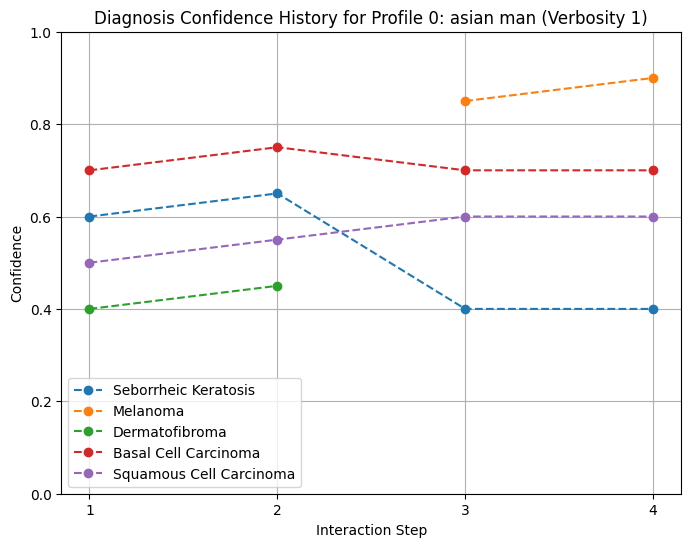

In [38]:
def plot_profile_diagnosis_confidence(profiles, index):
    """
    Plots the diagnosis confidence history for a specific patient profile.
    
    Args:
        profiles: List of patient profile dictionaries.
        index: Index of the profile in the list.
    """
    if index < 0 or index >= len(profiles):
        print("Invalid profile index.")
        return

    profile = profiles[index]
    diagnosis_history = profile['profile']['interaction_metadata']['diagnosis_confidence_history']
    x = np.arange(1, len(next(iter(diagnosis_history.values()))) + 1)  # Get step count
    ethnicity, gender, verbosity = profile['profile']['ethnicity'], profile['profile']['gender'], 1
    title = f"Diagnosis Confidence History for Profile {index}: {ethnicity} {gender} (Verbosity {verbosity})"

    plt.figure(figsize=(8, 6))
    for diagnosis, conf_values in diagnosis_history.items():
        plt.plot(x, conf_values, marker='o', linestyle="--", label=diagnosis)

    plt.xlabel("Interaction Step")
    plt.ylabel("Confidence")
    plt.title(title)
    plt.ylim(0, 1.0)
    plt.xticks(x)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_profile_diagnosis_confidence(profiles, 0)

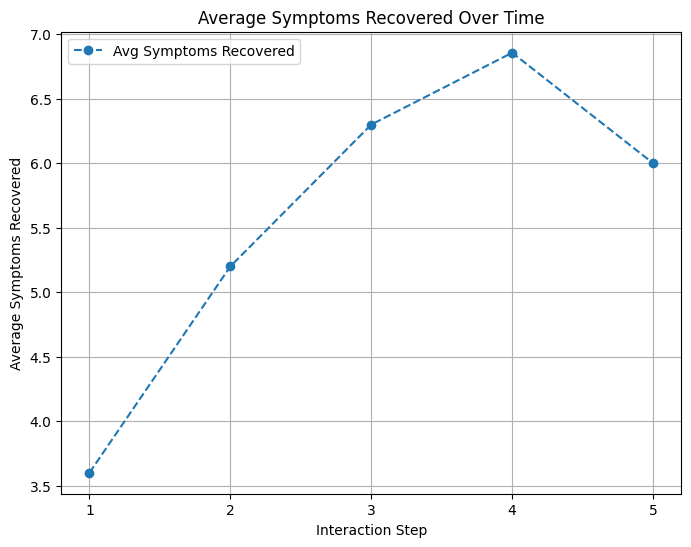

In [40]:
def plot_avg_symptoms_recovered(profiles, filters=None):
    """
    Plots the average number of symptoms recovered over interaction steps across all profiles 
    or a filtered subset based on specified criteria.

    Args:
        profiles: List of patient profile dictionaries.
        filters: Dictionary of filter conditions (e.g., {'ethnicity': 'Asian', 'gender': 'Man'}).
    """
    # Apply multiple filters
    def profile_matches(profile):
        metadata = profile['profile']
        return all(metadata.get(k, "") == v for k, v in (filters or {}).items())

    filtered_profiles = [p for p in profiles if profile_matches(p)]

    if not filtered_profiles:
        print(f"No profiles match the filters: {filters}")
        return

    max_steps = 5  # Profiles have at most 5 steps
    all_symptoms = []

    # Collect symptom recovery history
    for p in filtered_profiles:
        symptom_history = p['profile']['interaction_metadata']['num_symptoms_recovered_history']
        padded_history = symptom_history + [np.nan] * (max_steps - len(symptom_history))  # Pad with NaNs
        all_symptoms.append(padded_history[:max_steps])  # Ensure exact length

    # Convert to NumPy array for processing
    all_symptoms = np.array(all_symptoms, dtype=np.float64)

    # Compute mean while ignoring NaNs
    avg_symptoms = np.nanmean(all_symptoms, axis=0)

    # Plot results
    x = np.arange(1, max_steps + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(x, avg_symptoms, marker='o', linestyle="--", label="Avg Symptoms Recovered")

    plt.xlabel("Interaction Step")
    plt.ylabel("Average Symptoms Recovered")
    plt.title("Average Symptoms Recovered Over Time")
    plt.xticks(x)  # Ensure integer x-axis
    plt.grid(True)
    plt.legend()
    plt.show()

filters = {
    "ethnicity": "asian",
    "gender": "man"
}
plot_avg_symptoms_recovered(profiles)

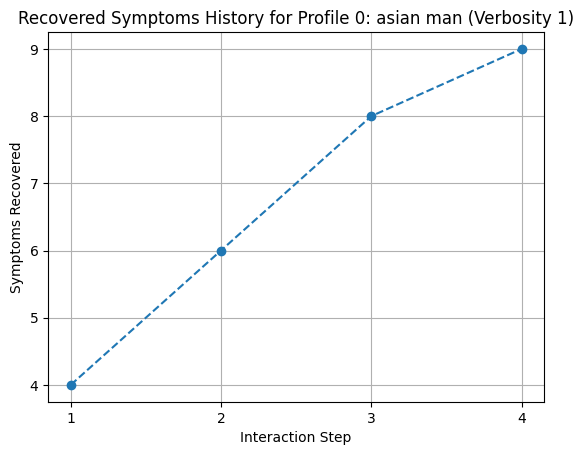

In [41]:
def plot_profile_symptoms_recovered(profiles, index):
    """
    Plots the number of symptoms recovered for a specific patient profile.
    
    Args:
        profiles: List of patient profile dictionaries.
        index: Index of the profile in the list.
    """
    if index < 0 or index >= len(profiles):
        print("Invalid profile index.")
        return

    profile = profiles[index]
    y = profile['profile']['interaction_metadata']['num_symptoms_recovered_history']
    x = np.arange(1, len(y) + 1)

    plt.plot(x, y, marker='o', linestyle="--")

    ethnicity, gender, verbosity = profile['profile']['ethnicity'], profile['profile']['gender'], 1
    title = f"Recovered Symptoms History for Profile {index}: {ethnicity} {gender} (Verbosity {verbosity})"

    plt.xlabel("Interaction Step")
    plt.ylabel("Symptoms Recovered")
    plt.title(title)
    plt.xticks(x)
    plt.yticks(range(min(y), max(y) + 1))
    plt.grid(True)
    plt.show()

plot_profile_symptoms_recovered(profiles, 0)


In [42]:
def compute_diagnosis_success_rate(profiles, filters=None):
    """
    Computes the diagnosis success rate across all profiles or a filtered subset.

    Args:
        profiles: List of patient profile dictionaries.
        filters: Dictionary of filter conditions (e.g., {'ethnicity': 'Asian', 'gender': 'Man'}).

    Returns:
        float: Success rate (0 to 1) or None if no matching profiles.
    """
    # Apply filters
    def profile_matches(profile):
        metadata = profile['profile']
        return all(metadata.get(k, "") == v for k, v in (filters or {}).items())

    filtered_profiles = [p for p in profiles if profile_matches(p)]

    if not filtered_profiles:
        print(f"No profiles match the filters: {filters}")
        return None

    # Count successes
    success_count = sum(p['profile']['interaction_metadata']['diagnosis_success'] for p in filtered_profiles)
    total_count = len(filtered_profiles)

    return success_count / total_count

compute_diagnosis_success_rate(profiles)

0.4

In [43]:
def compute_avg_interaction_duration(profiles, filters=None):
    """
    Computes the average interaction duration (in steps) across all profiles or a filtered subset.

    Args:
        profiles: List of patient profile dictionaries.
        filters: Dictionary of filter conditions (e.g., {'ethnicity': 'Asian', 'gender': 'Man'}).

    Returns:
        float: Average interaction duration or None if no matching profiles.
    """
    # Apply filters
    def profile_matches(profile):
        metadata = profile['profile']
        return all(metadata.get(k, "") == v for k, v in (filters or {}).items())

    filtered_profiles = [p for p in profiles if profile_matches(p)]

    if not filtered_profiles:
        print(f"No profiles match the filters: {filters}")
        return None

    # Collect interaction durations
    durations = [p['profile']['interaction_metadata']['interaction_duration'] for p in filtered_profiles]

    return np.mean(durations)

compute_avg_interaction_duration(profiles)


4.0